In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp
import time
from tqdm import tqdm

In [2]:
def solve_hetdp_cor(eps, k, beta, num_solver):
	n = len(eps)
	ones = np.ones(n)

	w = cp.Variable(n)
	objective2 = cp.Minimize(cp.power(cp.norm(w/eps,'inf'),2)*((np.log(k/beta))**2) + cp.power(cp.norm(w - (ones/n),1),2))
	constraints2 = [0 <= w, w@ones == 1]
	prob2 = cp.Problem(objective2, constraints2)
	result2 = prob2.solve(solver = num_solver)

	return w.value, np.sqrt(result2)



def solve_hetdp_uncor(eps, k, beta, num_solver):
	n = len(eps)
	ones = np.ones(n)

	w = cp.Variable(n)
	objective1 = cp.Minimize(cp.power(cp.norm(w/eps,'inf'),2)*((np.log(k/beta))**2) + cp.power(cp.norm(w - (ones/n),1),2))
	constraints1 = [0 <= w, w@ones == 1]
	prob1 = cp.Problem(objective1, constraints1)
	result1 = prob1.solve(solver = num_solver)

	w2 = cp.Variable(n)
	objective2 = cp.Minimize(cp.power(cp.norm(w2/eps,'inf'),2)*((np.log(k/beta))**2) + cp.power(cp.norm(w2,2),2)*np.log(k/beta))
	constraints2 = [0 <= w2, w2@ones == 1]
	prob2 = cp.Problem(objective2, constraints2)
	result2 = prob2.solve(solver = num_solver)

	if result1 < result2:
		return w.value, np.sqrt(result1)
	else:
		return w2.value, np.sqrt(result2)

In [3]:
def LDP(eps, Data, trials):
	n = len(eps)

	response_noise = np.random.laplace(0, 1/eps, (trials, n))
	ldp_data = Data + response_noise
	return ldp_data

In [4]:
def get_error(est,mean):
	return min(np.abs(est - mean),1)
def get_error_vector(est,mean):
	## est is trials 
	return np.minimum(np.abs(est-mean),1)
	

In [5]:
def gen_dataset(n,k, lamb=1):

	p = np.power(lamb,np.arange(k))
	p = p/np.sum(p)

	D = np.random.choice(k, size = n, p = p)
	DMatrix = np.zeros((k,n))
	for i in range(n):
		DMatrix[D[i],i] = 1
	
	counts = np.sum(DMatrix,axis=1)
	return DMatrix, counts

## UC Salary, C, P

In [28]:
## Real Dataset
np.random.seed(1)
df =  pd.read_csv('UCData.csv')
x = np.array(df['TotalWages'])

x = np.random.choice(x,50000,replace=False) #sub-sample dataset
x = x/5000000

bins = [0,np.quantile(x,0.1),np.quantile(x,0.2),np.quantile(x,0.3),np.quantile(x,0.4),np.quantile(x,0.5),np.quantile(x,0.6),np.quantile(x,0.7),np.quantile(x,0.8),np.quantile(x,0.9),500000]
def get_bin(x,bins):
	return np.digitize(x,bins) - 1

eps = np.zeros(len(x))
for i in range(len(x)):
	eps[i] = np.exp(-2*abs(get_bin(x[i],bins)-4.5) + 2)

In [29]:
### Correlated
np.random.seed(1)
beta = 0.05
n = len(x)
k = 1
trials = 5000

mean = np.mean(x)
print('Mean is ',np.mean(x))

### hpm-cp ###
begin = time.time()
w_hpmcp, result = solve_hetdp_cor(eps, k, beta, cp.ECOS)
L_hpmcp = np.max(w_hpmcp/eps)
N_hpmcp = np.random.laplace(0,L_hpmcp,trials)
end = time.time()
print('Done HPm-CP in ',end-begin,' seconds')


### hpfa ###
begin = time.time()
w_hpfa = 1-np.exp(-eps)
w_hpfa = w_hpfa/np.sum(w_hpfa)
infty_norm = np.max(w_hpfa/eps)
L_hpfa = infty_norm
N_hpfa = np.random.laplace(0,L_hpfa,trials)
end = time.time()
print('Done HPF-A in ',end-begin,' seconds')


### Prop ###
begin = time.time()
w_prop = eps
w_prop = w_prop/np.sum(w_prop)
L_prop = np.max(w_prop/eps)
N_prop = np.random.laplace(0,L_prop,trials)
end = time.time()
print('Done Prop in ',end-begin,' seconds')


### UNI ###
begin = time.time()
eps1 = np.min(eps)
w_uni = np.ones(n)/n
L_uni = np.max(1/eps)/n
N_uni = np.random.laplace(0,L_uni,trials)
end = time.time()
print('Done UNI in ',end-begin,' seconds')


### SM ###
begin = time.time()
t = np.max(eps)
sm_bern_matrix = np.random.binomial(1,(np.exp(eps)-1)/(np.exp(t)-1), (trials,n))
N_sm = np.random.laplace(0,1/(t*np.sum(sm_bern_matrix, axis=1)),size = trials)
end = time.time()
print('Done SM in ',end-begin,' seconds')


### LDP ###
begin = time.time()
w_ldp = w_hpmcp
ldp_data_matrix = LDP(eps, x, trials)
end = time.time()
print('Done LDP in ',end-begin,' seconds')

### HPM-CE ###
begin = time.time()
w_hpmce, result = solve_hetdp_uncor(eps, np.e, 1, cp.ECOS)
L_hpmce = np.max(w_hpmce/eps)
N_hpmce = np.random.laplace(0,L_hpmce,trials)
end = time.time()
print('Done HPM-CE in ',end-begin,' seconds')

Mean is  0.012921387008
Done HPm-CP in  4.636638164520264  seconds
Done HPF-A in  0.005127906799316406  seconds
Done Prop in  0.0009846687316894531  seconds
Done UNI in  0.0008640289306640625  seconds
Done SM in  9.438791990280151  seconds
Done LDP in  9.59471321105957  seconds


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Done HPM-CE in  8.65012502670288  seconds


In [30]:
errors_hpmcp = get_error_vector(x@w_hpmcp + N_hpmcp.transpose(),mean)
errors_hpfa = get_error_vector(x@w_hpfa + N_hpfa.transpose(),mean)
errors_prop = get_error_vector(x@w_prop + N_prop.transpose(),mean)
errors_uni = get_error_vector(x@w_uni + N_uni.transpose(),mean)
errors_ldp = get_error_vector(ldp_data_matrix@w_ldp,mean)
est_sm = get_error_vector((x@sm_bern_matrix.transpose()/np.sum(sm_bern_matrix,axis=1) + N_sm).transpose(),mean)
errors_hpmce = get_error_vector(x@w_hpmce + N_hpmce.transpose(),mean)

In [31]:
params = {'text.usetex' : True,
          'font.size' : 11,
		  'legend.fontsize': 9,
          'legend.handlelength': 1.5,
          }
plt.rcParams.update(params) 

min_range = min(min(errors_hpfa),min(errors_hpmcp), min(errors_uni) , min(errors_ldp), min(errors_prop))
max_range = max(max(errors_hpfa),max(errors_hpmcp), max(errors_uni) , max(errors_ldp), max(errors_prop))

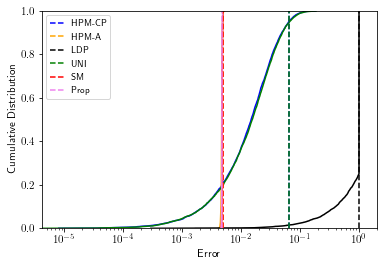

In [32]:
plt.xscale('log')

plt.plot(np.sort(errors_hpmcp), np.linspace(0, 1, len(errors_hpmcp), endpoint=False), alpha = 1,color='blue')
plt.plot(np.sort(errors_hpfa), np.linspace(0, 1, len(errors_hpfa), endpoint=False), alpha = 1,color='orange')
plt.plot(np.sort(errors_ldp), np.linspace(0, 1, len(errors_ldp), endpoint=False), alpha = 1,color='black')
plt.plot(np.sort(errors_uni), np.linspace(0, 1, len(errors_uni), endpoint=False), alpha = 1,color='green')
plt.plot(np.sort(est_sm), np.linspace(0, 1, len(est_sm), endpoint=False), alpha = 1,color='red')
plt.plot(np.sort(errors_prop), np.linspace(0, 1, len(errors_prop), endpoint=False), alpha = 1,color='violet')

plt.ylim(0,1)
plt.xlim(min_range, max_range*2)

plt.axvline(x = np.quantile(errors_hpmcp,0.95), color = 'blue', linestyle = '--', label=r'HPM-CP',)
plt.axvline(x = np.quantile(errors_hpfa,0.95), color = 'orange', linestyle = '--', label='HPM-A')
plt.axvline(x = np.quantile(errors_ldp,0.95), color = 'black', linestyle = '--', label='LDP')
plt.axvline(x = np.quantile(errors_uni,0.95), color = 'green', linestyle = '--', label='UNI')
plt.axvline(x = np.quantile(est_sm,0.95), color = 'red', linestyle = '--', label='SM')
plt.axvline(x = np.quantile(errors_prop,0.95), color = 'violet', linestyle = '--', label='Prop')


plt.xlabel('Error')
plt.ylabel('Cumulative Distribution')

plt.legend(loc='upper left')
plt.savefig("Mean-UC.pdf", 
            dpi=1000, 
            bbox_inches='tight', 
            )
plt.show()

In [33]:
print(np.quantile(errors_hpmcp,0.95), np.quantile(errors_hpfa,0.95), np.quantile(errors_uni,0.95), np.quantile(errors_ldp,0.95), np.quantile(est_sm,0.95), np.quantile(errors_prop,0.95))
print(np.mean(np.square(errors_hpmce)), np.mean(np.square(errors_hpfa)), np.mean(np.square(errors_uni)), np.mean(np.square(errors_ldp)), np.mean(np.square(est_sm)), np.mean(np.square(errors_prop)))


0.0642494066493151 0.004838815092663217 0.06581920900530491 1.0 0.004844978819755256 0.004803662512289334
1.8372224349364823e-05 2.1789462958482898e-05 0.0009739157371854958 0.8323620985404736 2.2684891171485783e-05 2.23406498451467e-05


In [34]:
## Saving performance:
errors_hpfc_UC = errors_hpmcp
errors_hpfa_UC = errors_hpfa
errors_ldp_UC = errors_ldp
errors_uni_UC = errors_uni
est_sm_UC = est_sm
errors_prop_UC = errors_prop
errors_hpmce_UC = errors_hpmce


## Correlated Synthetic k = 20

In [43]:
## Synthetic Dataset
np.random.seed(1)
beta = 0.05
n = 10000
k = 20


Data = np.zeros((k,n))
_, counts = gen_dataset(n,k,0.8)
ct = 0 
print(counts)
for i in range(len(counts)):
	Data[i,ct:ct+int(counts[i])] = 1
	ct += int(counts[i])
eps = np.zeros(n)
ct = 0 
for i in range(len(counts)):
	eps[ct:ct+int(counts[i])] = np.exp(5+np.random.uniform(-i*0.5,-i*0.5+0.5,int(counts[i])))
	ct += int(counts[i])


pi_char = np.exp(np.random.uniform(-1,1,k))
pi_char = pi_char/np.max(pi_char)

x = (pi_char @ Data)
mean = np.mean(x)
trials = 5000
k=1

print('Mean is ',mean)

### hpm-cp ###
begin = time.time()
w_hpmcp, result = solve_hetdp_cor(eps, k, beta, cp.ECOS)
L_hpmcp = np.max(w_hpmcp/eps)
N_hpmcp = np.random.laplace(0,L_hpmcp,trials)
end = time.time()
print('Done HPM-CP in ',end-begin,' seconds')


### hpfa ###
begin = time.time()
w_hpfa = 1-np.exp(-eps)
w_hpfa = w_hpfa/np.sum(w_hpfa)
infty_norm = np.max(w_hpfa/eps)
L_hpfa = infty_norm
N_hpfa = np.random.laplace(0,L_hpfa,trials)
end = time.time()
print('Done HPF-A in ',end-begin,' seconds')


### Prop ###
begin = time.time()
w_prop = eps
w_prop = w_prop/np.sum(w_prop)
L_prop = np.max(w_prop/eps)
N_prop = np.random.laplace(0,L_prop,trials)
end = time.time()
print('Done Prop in ',end-begin,' seconds')


### UNI ###
begin = time.time()
eps1 = np.min(eps)
w_uni = np.ones(n)/n
L_uni = np.max(1/eps)/n
N_uni = np.random.laplace(0,L_uni,trials)
end = time.time()
print('Done UNI in ',end-begin,' seconds')


### SM ###
begin = time.time()
t = np.max(eps)
sm_bern_matrix = np.random.binomial(1,(np.exp(eps)-1)/(np.exp(t)-1), (trials,n))
N_sm = np.random.laplace(0,1/(t*np.sum(sm_bern_matrix, axis=1)),size =trials)
end = time.time()
print('Done SM in ',end-begin,' seconds')


### LDP ###
begin = time.time()
w_ldp = w_hpmcp
ldp_data_matrix = LDP(eps, x, trials)
end = time.time()
print('Done LDP in ',end-begin,' seconds')


begin = time.time()
w_hpfce, result = solve_hetdp_cor(eps, np.e , 1, cp.ECOS)
L_hpfce = np.max(w_hpfce/eps)
N_hpfce = np.random.laplace(0,L_hpfce,trials)
end = time.time()
print('Done HPF-CE in ',end-begin,' seconds')


[2029. 1632. 1253. 1117.  794.  683.  527.  410.  344.  276.  217.  179.
  121.   88.   88.   82.   56.   49.   27.   28.]
Mean is  0.6287100174645548


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Done HPM-CP in  1.261347770690918  seconds
Done HPF-A in  0.0011129379272460938  seconds
Done Prop in  0.0019271373748779297  seconds
Done UNI in  0.0007040500640869141  seconds
Done SM in  1.3695788383483887  seconds
Done LDP in  1.7445909976959229  seconds
Done HPF-CE in  1.4795269966125488  seconds


In [44]:
errors_hpfc = get_error_vector(x@w_hpmcp + N_hpmcp.transpose(),mean)
errors_hpfa = get_error_vector(x@w_hpfa + N_hpfa.transpose(),mean)
errors_prop = get_error_vector(x@w_prop + N_prop.transpose(),mean)
errors_uni = get_error_vector(x@w_uni + N_uni.transpose(),mean)
errors_ldp = get_error_vector(ldp_data_matrix@w_ldp,mean)
errors_sm = get_error_vector((x@sm_bern_matrix.transpose()/np.sum(sm_bern_matrix,axis=1) + N_sm).transpose(),mean)
errors_hpfce = get_error_vector(x@w_hpfce + N_hpfce.transpose(),mean)

In [45]:
params = {'text.usetex' : True,
          'font.size' : 11,
		  'legend.fontsize': 9,
          'legend.handlelength': 1.5,
          }
plt.rcParams.update(params) 

min_range = min(min(errors_hpfa),min(errors_hpfc), min(errors_uni) , min(errors_ldp), min(errors_prop))
max_range = max(max(errors_hpfa),max(errors_hpfc), max(errors_uni) , max(errors_ldp), max(errors_prop))

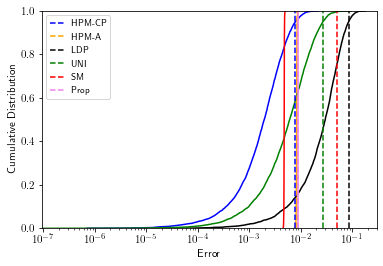

In [46]:
plt.xscale('log')

plt.plot(np.sort(errors_hpfc), np.linspace(0, 1, len(errors_hpfc), endpoint=False), alpha = 1,color='blue')
plt.plot(np.sort(errors_hpfa), np.linspace(0, 1, len(errors_hpfa), endpoint=False), alpha = 1,color='orange')
plt.plot(np.sort(errors_ldp), np.linspace(0, 1, len(errors_ldp), endpoint=False), alpha = 1,color='black')
plt.plot(np.sort(errors_uni), np.linspace(0, 1, len(errors_uni), endpoint=False), alpha = 1,color='green')
plt.plot(np.sort(est_sm), np.linspace(0, 1, len(est_sm), endpoint=False), alpha = 1,color='red')
plt.plot(np.sort(errors_prop), np.linspace(0, 1, len(errors_prop), endpoint=False), alpha = 1,color='violet')


plt.ylim(0,1)
plt.xlim(min_range, 0.3)

plt.axvline(x = np.quantile(errors_hpfc,0.95), color = 'blue', linestyle = '--', label='HPM-CP',)
plt.axvline(x = np.quantile(errors_hpfa,0.95), color = 'orange', linestyle = '--', label='HPM-A')
plt.axvline(x = np.quantile(errors_ldp,0.95), color = 'black', linestyle = '--', label='LDP')
plt.axvline(x = np.quantile(errors_uni,0.95), color = 'green', linestyle = '--', label='UNI')
plt.axvline(x = np.quantile(errors_sm,0.95), color = 'red', linestyle = '--', label='SM')
plt.axvline(x = np.quantile(errors_prop,0.95), color = 'violet', linestyle = '--', label='Prop')


plt.xlabel('Error')
plt.ylabel('Cumulative Distribution')

plt.legend(loc='upper left')
plt.savefig("Mean-CorrSyn2.pdf", 
            dpi=1000, 
            bbox_inches='tight', 
            )
plt.show()

In [47]:
print(np.quantile(errors_hpfc,0.95), np.quantile(errors_hpfa,0.95), np.quantile(errors_prop,0.95), np.quantile(errors_uni,0.95), np.quantile(errors_sm,0.95), np.quantile(errors_ldp,0.95) )
print(np.mean(np.square(errors_hpfce)), np.mean(np.square(errors_hpfa)), np.mean(np.square(errors_uni)), np.mean(np.square(errors_ldp)), np.mean(np.square(est_sm)), np.mean(np.square(errors_prop)))

0.007850711299104791 0.008585626937171558 0.008833198606203652 0.026805671118838442 0.051607144285564135 0.08508996628060134
3.5285199556761515e-05 6.951014862562402e-05 0.0001605310725804631 0.0019036234203458993 2.2684891171485783e-05 7.797281716817105e-05


In [44]:

### Saving results:
errors_hpfc_syn2 = errors_hpfc
errors_hpfa_syn2 = errors_hpfa
errors_ldp_syn2 = errors_ldp
errors_uni_syn2 = errors_uni
errors_sm_syn2 = errors_sm
errors_prop_syn2 = errors_prop



### Uncor Syn k=20

In [7]:
## Synthetic Dataset
np.random.seed(1)
beta = 0.05
n = 10000
k = 20


Data = np.zeros((k,n))
_, counts = gen_dataset(n,k,0.8)
ct = 0 
print(counts)
for i in range(len(counts)):
	Data[i,ct:ct+int(counts[i])] = 1
	ct += int(counts[i])
eps = np.zeros(n)
ct = 0 
for i in range(len(counts)):
	eps[ct:ct+int(counts[i])] = np.exp(5+np.random.uniform(-i*0.5,-i*0.5+0.5,int(counts[i])))
	ct += int(counts[i])


pi_char = np.exp(np.random.uniform(-1,1,k))
pi_char = pi_char/np.max(pi_char)

x = (pi_char @ Data)
mean = np.mean(x)
trials = 5000
k=1

print('Mean is ',mean)




### hpfu ###
begin = time.time()
w_hpmup, result = solve_hetdp_uncor(eps, k, beta, cp.ECOS)
L_hpfu = np.max(w_hpmup/eps)
N_hpfu = np.random.laplace(0,L_hpfu,trials)
end = time.time()
print('Done HPM-UP in ',end-begin,' seconds')


### hpfa ###
begin = time.time()
w_hpfa = 1-np.exp(-eps)
w_hpfa = w_hpfa/np.sum(w_hpfa)
infty_norm = np.max(w_hpfa/eps)
L_hpfa = infty_norm
N_hpfa = np.random.laplace(0,L_hpfa,trials)
end = time.time()
print('Done HPF-A in ',end-begin,' seconds')


### Prop ###
begin = time.time()
w_prop = eps
w_prop = w_prop/np.sum(w_prop)
L_prop = np.max(w_prop/eps)
N_prop = np.random.laplace(0,L_prop,trials)
end = time.time()
print('Done Prop in ',end-begin,' seconds')


### UNI ###
begin = time.time()
eps1 = np.min(eps)
w_uni = np.ones(n)/n
L_uni = np.max(1/eps)/n
N_uni = np.random.laplace(0,L_uni,trials)
end = time.time()
print('Done UNI in ',end-begin,' seconds')


### hpfue ###
begin = time.time()
w_hpmue, result = solve_hetdp_uncor(eps, np.e , 1, cp.ECOS)
L_hpmue = np.max(w_hpmue/eps)
N_hpmue = np.random.laplace(0,L_hpmue,trials)
end = time.time()
print('Done HPF-UE in ',end-begin,' seconds')


### LDP ###
begin = time.time()
w_ldp = w_hpmup
end = time.time()
print('Done LDP in ',end-begin,' seconds')


### SM ###
begin = time.time()
t = np.max(eps)
sm_bern_matrix = np.random.binomial(1,(np.exp(eps)-1)/(np.exp(t)-1), (trials,n))
N_sm = np.random.laplace(0,1/(t*np.sum(sm_bern_matrix, axis=1)),size = trials)
end = time.time()
print('Done SM in ',end-begin,' seconds')


[2029. 1632. 1253. 1117.  794.  683.  527.  410.  344.  276.  217.  179.
  121.   88.   88.   82.   56.   49.   27.   28.]
Mean is  0.6287100174645548
Done HPM-UP in  2.6720499992370605  seconds
Done HPF-A in  0.0015461444854736328  seconds
Done Prop in  0.0008249282836914062  seconds
Done UNI in  0.0010139942169189453  seconds
Done HPF-UE in  2.1381969451904297  seconds
Done LDP in  0.0001888275146484375  seconds
Done SM in  1.6588718891143799  seconds


In [8]:
errors_hpfu = np.zeros(trials)
errors_hpfa = np.zeros(trials)
errors_prop = np.zeros(trials)
errors_uni = np.zeros(trials)
errors_hpfue = np.zeros(trials)
errors_ldp = np.zeros(trials)
errors_sm = np.zeros(trials)


for _ in tqdm(range(trials)):
	np.random.shuffle(x)
	

	est_hpfu= x@w_hpmup + N_hpfu[_]
	est_hpfa = x@w_hpfa + N_hpfa[_]
	est_uni = x@w_uni + N_uni[_]
	est_prop = x@w_prop + N_prop[_]
	est_hpfue = x@w_hpmue + N_hpmue[_]
	est_ldp = LDP(eps, x, 1)[0]@w_ldp
	est_sm = (x@sm_bern_matrix.transpose()/np.sum(sm_bern_matrix,axis=1) + N_sm)[_]

	errors_hpfu[_]= get_error(est_hpfu,mean)
	errors_hpfa[_]= get_error(est_hpfa,mean)
	errors_uni[_]= get_error(est_uni,mean)
	errors_prop[_]= get_error(est_prop,mean)
	errors_hpfue[_]= get_error(est_hpfue,mean)
	errors_ldp[_]= get_error(est_ldp,mean)
	errors_sm[_]= get_error(est_sm,mean)

100%|██████████| 5000/5000 [40:35<00:00,  2.05it/s]


In [51]:
params = {'text.usetex' : True,
          'font.size' : 11,
		  'legend.fontsize': 9,
          'legend.handlelength': 1.5,
          }
plt.rcParams.update(params) 

min_range = min(min(errors_hpfa),min(errors_hpfu), min(errors_uni) , min(errors_prop))
max_range = max(max(errors_hpfa),max(errors_hpfu), max(errors_uni) , max(errors_prop))

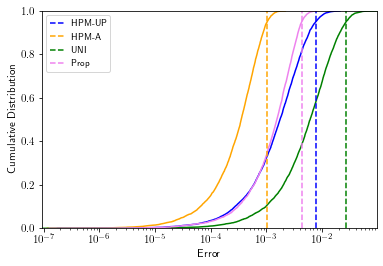

In [52]:
plt.xscale('log')

plt.plot(np.sort(errors_hpfu), np.linspace(0, 1, len(errors_hpfu), endpoint=False), alpha = 1,color='blue')
plt.plot(np.sort(errors_hpfa), np.linspace(0, 1, len(errors_hpfa), endpoint=False), alpha = 1,color='orange')
plt.plot(np.sort(errors_uni), np.linspace(0, 1, len(errors_uni), endpoint=False), alpha = 1,color='green')
plt.plot(np.sort(errors_prop), np.linspace(0, 1, len(errors_prop), endpoint=False), alpha = 1,color='violet')

plt.ylim(0,1)
plt.xlim(min_range, max_range)

plt.axvline(x = np.quantile(errors_hpfu,0.95), color = 'blue', linestyle = '--', label='HPM-UP',)
plt.axvline(x = np.quantile(errors_hpfa,0.95), color = 'orange', linestyle = '--', label='HPM-A')
plt.axvline(x = np.quantile(errors_uni,0.95), color = 'green', linestyle = '--', label='UNI')
plt.axvline(x = np.quantile(errors_prop,0.95), color = 'violet', linestyle = '--', label='Prop')


plt.xlabel('Error')
plt.ylabel('Cumulative Distribution')

plt.legend(loc='upper left')
plt.savefig("Mean-UncorSyn2.pdf", 
            dpi=1000, 
            bbox_inches='tight', 
            )
plt.show()

In [9]:
print(np.quantile(errors_hpfu,0.95), np.quantile(errors_hpfa,0.95), np.quantile(errors_prop,0.95), np.quantile(errors_uni,0.95), np.quantile(errors_ldp,0.95), np.quantile(errors_sm,0.95) )
print(np.mean(np.square(errors_hpfue)), np.mean(np.square(errors_hpfa)), np.mean(np.square(errors_uni)), np.mean(np.square(errors_prop)), np.mean(np.square(errors_ldp)), np.mean(np.square(errors_sm)))

0.0076874031133905354 0.001014849485146635 0.004336836895818475 0.026805671118838244 0.08627373774642576 0.10956808167409222
3.526183871564627e-05 2.680786051111403e-07 0.00016053107258046315 4.841537944626555e-06 0.0018877073889268627 0.0032076514511730652


# Mean Estimation

In [61]:
def solve_ldp_cor(eps, k, beta):
	n = len(eps)
	ones = np.ones(n)
	coefs = n+((np.log(k/beta))/np.square(eps))

	w = 1/coefs
	w = w/np.sum(w)
	return w, 1

def solve_ldp_uncor(eps, k, beta):
	n = len(eps)
	ones = np.ones(n)
	coefs = 1+(1/np.square(eps))

	w = 1/coefs
	w = w/np.sum(w)
	return w, 1

## UC Salary, C, P

In [66]:
## Real Dataset
np.random.seed(1)
df =  pd.read_csv('UCData.csv')
x = np.array(df['TotalWages'])
print(np.min(x),np.max(x))
print(len(x))
x = np.random.choice(x,50000,replace=False) #sub-sample dataset

def get_bin(x):
	if x < 1000:
		return 0
	elif x < 5000:
		return 1
	elif x < 15000:
		return 2
	elif x < 30000:
		return 3
	elif x < 60000:
		return 4
	elif x < 120000:
		return 5
	elif x < 240000:
		return 6
	elif x < 480000:
		return 7
	elif x < 960000:
		return 8
	elif x < 2000000:
		return 9
	elif x < 4000000:
		return 10
	else:
		return 11

np.random.seed(1)
eps = np.zeros(len(x))
ct = 0 
for i in range(len(x)):
	eps[i] = np.exp(-abs(get_bin(x[i])-2.5) + np.random.uniform(-3,3))

### Correlated
np.random.seed(1)
beta = 0.05
n = len(x)
k = 1
trials = 5000
scale = 10000000

Data = x
mean = np.sum(Data)/n
print('Mean is ',mean)

### hpfc ###
begin = time.time()
w_hpfc, result = solve_hetdp_cor(eps, k, beta, cp.ECOS)
L_hpfc = np.max(scale*w_hpfc/eps)
N_hpfc = np.random.laplace(0,L_hpfc,trials)
end = time.time()
print('Done HPM-CP in ',end-begin,' seconds')


### hpfa ###
begin = time.time()
w_hpfa = 1-np.exp(-eps)
w_hpfa = w_hpfa/np.sum(w_hpfa)
infty_norm = np.max(scale*w_hpfa/eps)
L_hpfa = infty_norm
N_hpfa = np.random.laplace(0,L_hpfa,trials)
end = time.time()
print('Done HPF-A in ',end-begin,' seconds')


### Prop ###
begin = time.time()
w_prop = eps
w_prop = w_prop/np.sum(w_prop)
L_prop = scale*np.max(w_prop/eps)
N_prop = np.random.laplace(0,L_prop,trials)
end = time.time()
print('Done Prop in ',end-begin,' seconds')


### UNI ###
begin = time.time()
eps1 = np.min(eps)
w_uni = np.ones(n)/n
L_uni = scale*np.max(1/eps)/n
N_uni = np.random.laplace(0,L_uni,trials)
end = time.time()
print('Done UNI in ',end-begin,' seconds')


### SM ###
begin = time.time()
t = np.max(eps)
sm_bern_matrix = np.random.binomial(1,(np.exp(eps)-1)/(np.exp(t)-1), (trials,n))
N_sm = np.random.laplace(0,scale/(t*np.sum(sm_bern_matrix, axis=1)),size = trials)
end = time.time()
print('Done SM in ',end-begin,' seconds')


### LDP ###
begin = time.time()
w_ldp, result = solve_ldp_cor(eps, k, beta)
ldp_data_matrix = kRAPPOR_cor(eps, Data, trials)
end = time.time()
print('Done LDP in ',end-begin,' seconds')

1 5770000
324043
Mean is  64606.93504


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Done HPM-CP in  10.57554006576538  seconds
Done HPF-A in  0.007319927215576172  seconds
Done Prop in  0.003594636917114258  seconds
Done UNI in  0.003741025924682617  seconds
Done SM in  9.865974187850952  seconds


In [65]:
print(eps)

[-0.41578297  1.40403196 -2.39278309 ...  1.81251171 -2.74661975
  2.27919947]
